# 1. Importing libraries and datasets

## 1.1 Importing torch

In [1]:
import torch
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## 1.2 Importing language detection

- For Malay, we use dictionaries from IPA-Dict and Dewan Bahasa.
- For English, we use NLTK corpus.

In [2]:
import json
import nltk

# my_raw1 = json.load(open('../dictionary/200k-english-malay.json'))
# my_raw2 = open('../dictionary/en-ms.txt', encoding="utf8")
# my_raw3 = open('../dictionary/malay-ipa-dict.txt', encoding="utf8")

# my_raw1 = [x[1] for x in my_raw1]
# my_raw2 = [x.split('\t')[1].strip() for x in my_raw2.readlines()]
# my_raw3 = [x.split('\t')[0] for x in my_raw3.readlines()]

# with open('../dictionary/combined-malay-dict.txt', 'w', encoding="utf8") as fp:
#     for item in sorted(list(dict.fromkeys(my_raw1 + my_raw2 + my_raw3))):
#         if item:
#             fp.write("%s\n" % item)

with open('../dictionary/combined-malay-dict.txt', encoding="utf8") as fp:
    malay_dict = [x.strip() for x in fp.readlines()]
    
def detect_malay(text): return text in malay_dict
def detect_english(text): return text in nltk.corpus.words.words()

## 1.3 Importing and combining datasets

In [5]:
# # install pandas
# !pip install pandas

import pandas as pd
combined_df = pd.DataFrame()

# local-new: text + label*
df = pd.read_csv(r'../data/malaya/local-news.csv')
combined_df = pd.concat([combined_df, df[['text', 'label']].rename(columns={'label': 'sentiment'})])

# semisupervised-bert-xlnet: text + label*
df = pd.read_csv(r'../data/malaya/semisupervised-bert-xlnet.csv')
combined_df = pd.concat([combined_df, df[['text', 'label']].rename(columns={'label': 'sentiment'})])

# semisupervised-bert-xlnet: text + label*
df = pd.read_csv(r'../data/malaya/semisupervised-politics-bert-xlnet.csv')
combined_df = pd.concat([combined_df, df[['text', 'label']].rename(columns={'label': 'sentiment'})])

# supervised-data: text + sentiment* 
df = pd.read_csv(r'../data/malaya/supervised-data.csv', sep='\t')
combined_df = pd.concat([combined_df, df[['text', 'sentiment']]])

# supervised-data-politics: text + sentiment* 
df = pd.read_csv(r'../data/malaya/supervised-data-politics.csv', sep='\t')
combined_df = pd.concat([combined_df, df[['text', 'sentiment']]])

# supervised-data-politics: text + sentiment* 
df = pd.read_csv(r'../data/malaya/manglish.csv', sep='\t')
df['sentiment'] = df['sentiment'].apply(lambda x: x.capitalize())
combined_df = pd.concat([combined_df, df[['text', 'sentiment']]])

combined_df = combined_df.reset_index()[['text', 'sentiment']]
combined_df

,text,sentiment
0,Lebih-lebih lagi dengan kemudahan internet da...,Negative
1,boleh memberi teguran kepada parti tetapi perl...,Positive
2,Adalah membingungkan mengapa masyarakat Cina b...,Negative
3,Kami menurunkan defisit daripada 6.7 peratus p...,Positive
4,"Ini masalahnya. Bukan rakyat, tetapi sistem",Negative
...,...,...
515513,what game she play?,Negative
515514,Lots of PS3...,Positive
515515,"Can't see the titles, but one of them says Bin...",Neutral
515516,Those look like old PS3 games.,Negative


# 2. Data preprocessing

## 2.1 Data Cleaning

In [16]:
from unidecode import unidecode
import string
import re

punctuation = '‘’“”!$%&\()*+,./:;<=>?[\\]^_`{|}~•@…'

def clean_text(text):
    # convert characters to ascii
    text = unidecode(text)
    
    # remove words that is hashtags, mentions and links
    text = re.sub(r'^([@#]|http|https)[^\s]*', '', text)
    
    # remove punctuation
    text = text.translate(text.maketrans('', '', punctuation))
    
    # remove next line     
    text = re.sub('\n', '', text)
    
    # lowercasing text
    text = text.lower()
    
    # stripping text
    text = text.strip()
    
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text
    
combined_df['text'] = combined_df['text'].apply(lambda x: clean_text(x))
combined_df

,text,sentiment
0,lebih-lebih lagi dengan kemudahan internet da...,Negative
1,boleh memberi teguran kepada parti tetapi perl...,Positive
2,adalah membingungkan mengapa masyarakat cina b...,Negative
3,kami menurunkan defisit daripada peratus pada...,Positive
4,ini masalahnya bukan rakyat tetapi sistem,Negative
...,...,...
215513,kerajaan kita bukan serba boleh tapi serba bod...,Negative
215514,sudah sudah la kak mas woi kamu tahu tak semua...,Negative
215515,nape nak kena tampal gambar dia pulakguna duit...,Negative
215516,bendera putih tu bukannya nak harap bantuan ke...,Negative


## 2.2 Normalise short-form words

In [18]:
malaya_sf = pd.read_csv(r'../normalise/malaya.csv')
cilisos_sf = pd.read_csv(r'../normalise/cilisos.csv', encoding='ISO-8859-1')

combined_sf = {x[0]: x[1] for x in malaya_sf.values.tolist() + cilisos_sf.values.tolist()}

def normalise_text(text):
    return ' '.join([combined_sf[x] if x in combined_sf.keys() else x for x in text.split()])

combined_df['text'] = combined_df['text'].apply(lambda x: normalise_text(x))
combined_df

,text,sentiment
0,lebih-lebih lagi dengan kemudahan internet dan...,Negative
1,boleh memberi teguran kepada parti tetapi perl...,Positive
2,adalah membingungkan mengapa masyarakat cina b...,Negative
3,kami menurunkan defisit daripada peratus pada ...,Positive
4,ini masalahnya bukan rakyat tetapi sistem,Negative
...,...,...
215513,kerajaan kita bukan serba boleh tetapi serba b...,Negative
215514,sudah sudah lah kak mas woi kamu tahu tidak se...,Negative
215515,kenapa hendak kena tampal gambar dia pulakguna...,Negative
215516,bendera putih itu bukannya hendak harap bantua...,Negative


# 3. Load tokenizer

## 3.1 Load customised modeling

Language embeddings will be added on model.

In [195]:
import torch
import modeling_bert

from modeling_bert import BertModel
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

C:\Users\cafer\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cafer\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

## 3.2 Testing datasets and modeling

In [196]:
# text = "She sells"
# # if we tokenize it, this becomes:
# encoding = tokenizer(text, return_tensors="pt")
# encoding['language_ids'] = torch.tensor([[0, 1, 1, 0]])

# print(encoding['input_ids'])

# for input_id in encoding['input_ids']:
#     print(tokenizer.decode(input_id))


tensor([[  101, 11149, 36300, 10107,   102]])
[CLS] She sells [SEP]


max:  232
min:  2


(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

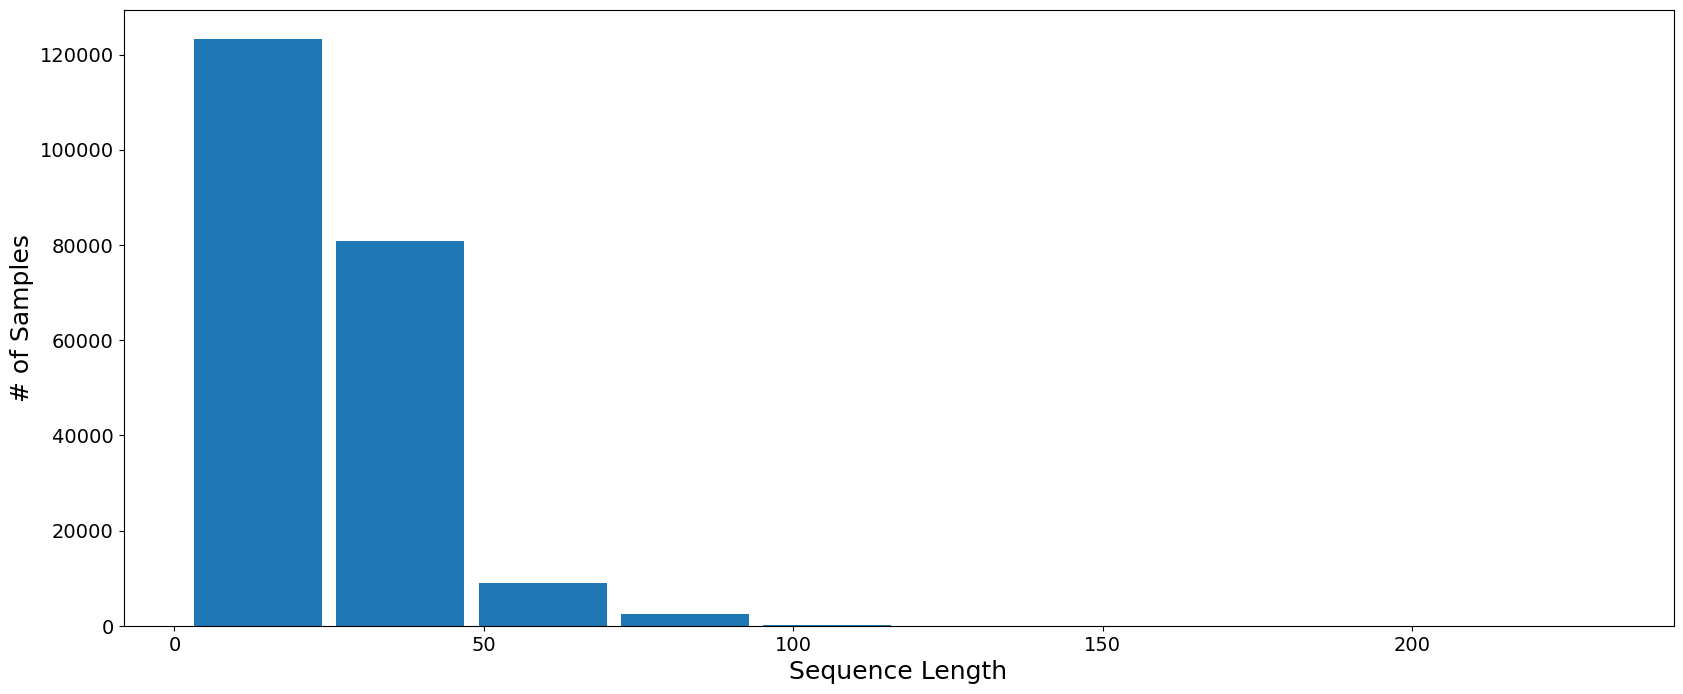

In [197]:
# # tokenize the text feature 
# tokenized_feature_raw = tokenizer.batch_encode_plus(
#     # Sentences to encode
#     combined_df.text.values.tolist(), 
#     # Add '[CLS]' and '[SEP]'
#     add_special_tokens = True
# )

# # collect tokenized sentence length
# token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
# print('max: ', max(token_sentence_length))
# print('min: ', min(token_sentence_length))

# # plot the distribution
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20, 8))
# plt.hist(token_sentence_length, rwidth = 0.9)
# plt.xlabel('Sequence Length', fontsize = 18)
# plt.ylabel('# of Samples', fontsize = 18)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)

## 3.3 Tokenize features

In [198]:
# identify features and target
features = combined_df.text.values.tolist()
target = combined_df.sentiment.values.tolist()

print(features[:5])

['lebih-lebih lagi dengan kemudahan internet dan laman sosial taktik ini semakin mudah dikembangkan', 'boleh memberi teguran kepada parti tetapi perlu ikut cara yang betul', 'adalah membingungkan mengapa masyarakat cina bersorak gembira apabila mahathir menyertai gabungan pakatan pembangkang', 'kami menurunkan defisit daripada peratus pada tahun kepada tiga peratus pada tahun lalu', 'ini masalahnya bukan rakyat tetapi sistem']


In [199]:
# tokenize features 
MAX_LEN = 128
tokenized_feature = tokenizer.batch_encode_plus(
    # Sentences to encode
    features, 
    # Add '[CLS]' and '[SEP]'
    add_special_tokens = True,
    # Add empty tokens if len(text)<MAX_LEN
    padding = 'max_length',
    # Truncate all sentences to max length
    truncation=True,
    # Set the maximum length
    max_length = MAX_LEN, 
    # Return attention mask
    return_attention_mask = True,
    # Return pytorch tensors
    return_tensors = 'pt'       
)

## 3.4 Add language embeddings

In [200]:
special_token_list = ['[CLS]', '[SEP]', '[PAD]', '[UNK]']

lang_id2num = { 'special_token': 0, 'english': 1, 'malay': 2, 'other': 3 }
lang_num2id = {v:k for k,v in lang_id2num.items()}

In [201]:
def detect_lang(text):
    if text in special_token_list:
        return 'special_token'
    elif detect_malay(text):
        return 'malay'
    elif detect_english(text):
        return 'english'
    else:
        return 'other'
    
def get_lang_tokens(input_tokens):
    language_ids = []
    
    full_sentence = ''
    token_count = 0
    for input_token in reversed(input_tokens):
        token = tokenizer.decode(input_token).replace(' ', '')
        
        if '##' in token:
            full_sentence = token.split('##')[1] + full_sentence
            token_count += 1
            continue
        else:
            full_sentence = token + full_sentence
            token_count += 1
        
        lang_token = lang_id2num[detect_lang(full_sentence)]
        for _ in range(token_count):
            language_ids.append(lang_token)
        
        full_sentence = ''
        token_count = 0
        
    return list(reversed(language_ids))

In [212]:
language_ids = []

for input_id in tokenized_feature['input_ids']:
    input_tokens = input_id.tolist()
    
    language_ids.append(get_lang_tokens(input_tokens))

language_ids = torch.tensor(language_ids)

tokenized_feature['language_ids'] = language_ids

KeyboardInterrupt: 

In [ ]:
tokenized_feature['language_ids']